# Exploratory Data Analysis (EDA).
This is the notebook I made for lecture 3, where we did EDA.

## Summary
This notebook explores the following:
- **Articles**
  - Relation between `article_id` and `product_code`
  - `article_id` has prefix 0 on all IDs, but pandas doesn't read them in correctly
- **Images**
  - **Does not having an image impact article popularity?**
    - No $\Rightarrow$ mean, min, max article popularities are similar
  - **How are articles without images distributed across garment groups?**
    - Most articles without images are "Shoes" or "Accessories"
  - **Which articles without an image actually get bought?**
    - Most bought articles without image are in "Jersey" garment group
- **Customers**
  - `FN` and `Active` unique values: {1, NaN} 
    - convert NaN to 0
  - Illogical combinations of `FN` and `fashion_news_frequency`

      | FN  | fashion_news_frequency  |
      |:---:|:-----------------------:|
      | NaN | 'Monthly'               |
      | NaN | 'Regularly'             |
      | 1   | 'NONE'                  |
      | 1   | 'None'                  |



---

## Setup

In [1]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.utils import DATA_PATH

In [2]:
articles = pd.read_csv(f'{DATA_PATH}/articles.csv')
customers = pd.read_csv(f'{DATA_PATH}/customers.csv')
sample_submisison = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
transactions = pd.read_csv(f'{DATA_PATH}/transactions_train.csv')

## Articles

In [3]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [4]:
# show for each column in articles the NaN count and ratio
articles.isna().sum().to_frame().rename(columns={0: 'NaN count'}).assign(
    ratio=lambda x: x['NaN count']/customers.shape[0]
)

,NaN count,ratio
article_id,0,0.000000
product_code,0,0.000000
prod_name,0,0.000000
product_type_no,0,0.000000
product_type_name,0,0.000000
product_group_name,0,0.000000
graphical_appearance_no,0,0.000000
graphical_appearance_name,0,0.000000
colour_group_code,0,0.000000
colour_group_name,0,0.000000


We notice that, from the 5 article rows shown above, the `article_id` value seems to begin with the 6 numbers of the `product_code`. Let's check if this is true for all rows.

In [5]:
# are all product_code values of length 6?
articles['product_code'].apply(lambda x: len(str(x))).unique()


array([6])

In [6]:
# are all article_id values of length 9?
articles['article_id'].apply(lambda x: len(str(x))).unique()

array([9])

In [7]:
# do all article_id values start by the product_id?
articles.apply(lambda x: str(x.article_id)[:-3] == str(x.product_code), axis=1).unique()

array([ True])

We conclude that `article_id` is always of length 9, `product_code` is always of length 6, and the `article_id` always starts with `product_code`.

Are there any articles that have not been purchased (i.e., `article_id`s that do not occur in the transactions)?

In [8]:
# look how many articles have not been sold
not_sold = articles[~articles['article_id'].isin(transactions['article_id'])]
print(f"Unique article_id's in articles that were not sold: \t{not_sold['article_id'].nunique()}")
print(f"Percentage of articles that were not sold: \t\t{not_sold['article_id'].nunique()/articles['article_id'].nunique():.2%}")

Unique article_id's in articles that were not sold: 	995
Percentage of articles that were not sold: 		0.94%


Important to note is the fact that `article_id` and `product_code` are prefixed by a zero in the dataset. However, when reading the csv file using pandas, these columns are read as an integer and the prepending 0 is removed. 

For most use cases, this is not a big deal, except when using the article images. These images are divided into subfolders based on the article group, which is defind as the three first numbers of the `article_id`. In this case, the prefixed zero should not be forgotten.

## Images
Almost all articles have an image: only 442 out of 105542 articles don't have one.

In [9]:
# get all article_ids that have an image
image_group = os.listdir(f'{DATA_PATH}/images')
images = []
for group in image_group:
    images.extend([img[:-4] for img in os.listdir(f'{DATA_PATH}/images/{group}')])

print(f"Unique article_id's in articles:\t{articles['article_id'].nunique()}")
print(f"Unique article_id's with an image:\t{pd.Series(images).nunique()}")
print(f"Percentage of articles with an image:\t{pd.Series(images).nunique()/articles['article_id'].nunique():.2%}")

Unique article_id's in articles:	105542
Unique article_id's with an image:	105100
Percentage of articles with an image:	99.58%


#### Does not having an image impact article popularity?

In [10]:
# create new has_image column in transactions, which is True if the article_id has an image
transactions['has_image'] = transactions['article_id'].apply(lambda x: "0" + str(x)).isin(images)

In [11]:
# get popularity of all articles with image
popularity_image = transactions['article_id'][transactions['has_image'] == True].value_counts()
print("Popularity of articles with image:")
popularity_image.describe()

Popularity of articles with image:


count    104106.000000
mean        304.033178
std         783.491375
min           1.000000
25%          14.000000
50%          65.000000
75%         287.000000
max       50287.000000
Name: article_id, dtype: float64

In [12]:
# get popularity of articles without an image
popularity_no_image = transactions['article_id'][transactions['has_image'] == False].value_counts()
print("Popularity of articles without image:")
popularity_no_image.describe()

Popularity of articles without image:


count      441.000000
mean       309.854875
std       1877.304004
min          1.000000
25%          5.000000
50%         20.000000
75%         89.000000
max      30199.000000
Name: article_id, dtype: float64

We see that the mean, min and max are somewhat similar, so we can say that the popularity of an article is not affected much by whether or not there is an image available.

#### How are articles without images distributed across garment groups?

In [13]:
articles_with_image = articles[articles['article_id'].isin(transactions['article_id'][transactions['has_image'] == True])]
articles_no_image = articles[articles['article_id'].isin(transactions['article_id'][transactions['has_image'] == False])]

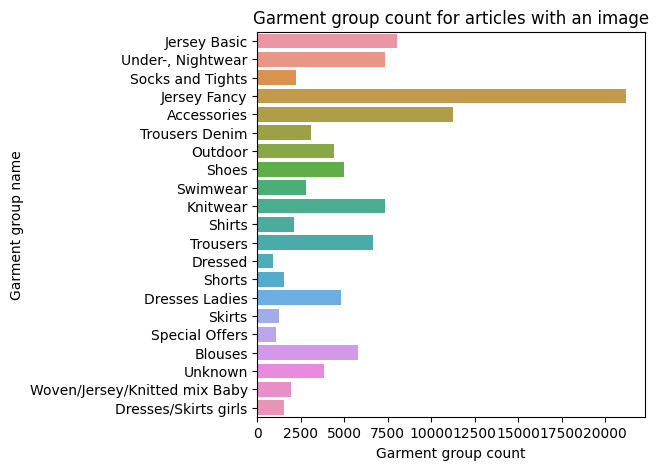

In [14]:
garment_group_names = articles['garment_group_name'].unique().tolist()

# plot the distribution of the popularity of articles with image
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(data=articles_with_image, y='garment_group_name', order=garment_group_names)
ax.set_xlabel('Garment group count')
ax.set_ylabel('Garment group name')
ax.set_title('Garment group count for articles with an image')
plt.show()

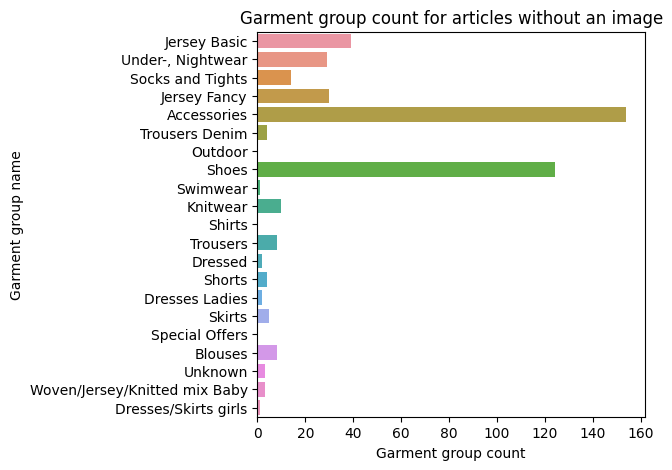

In [15]:
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(data=articles_no_image, y='garment_group_name', order=garment_group_names)
ax.set_xlabel('Garment group count')
ax.set_ylabel('Garment group name')
ax.set_title('Garment group count for articles without an image')
plt.show()

Most articles without images are in the Accessories and Shoes garment groups.

#### Which articles without an image actually get bought?

In [16]:
transactions_with_image = transactions[transactions['has_image'] == True].merge(articles[['article_id', 'garment_group_name']], on='article_id')
transactions_no_image = transactions[transactions['has_image'] == False].merge(articles[['article_id', 'garment_group_name']], on='article_id')

In [17]:
print(f"Amount of transactions with image: \t\t{transactions_with_image.shape[0]}")
print(f"Amount of transactions without image: \t\t{transactions_no_image.shape[0]}")
print(f"Percentage of transactions without image: \t{transactions_no_image.shape[0]/transactions.shape[0]:.2%}")

Amount of transactions with image: 		31651678
Amount of transactions without image: 		136646
Percentage of transactions without image: 	0.43%


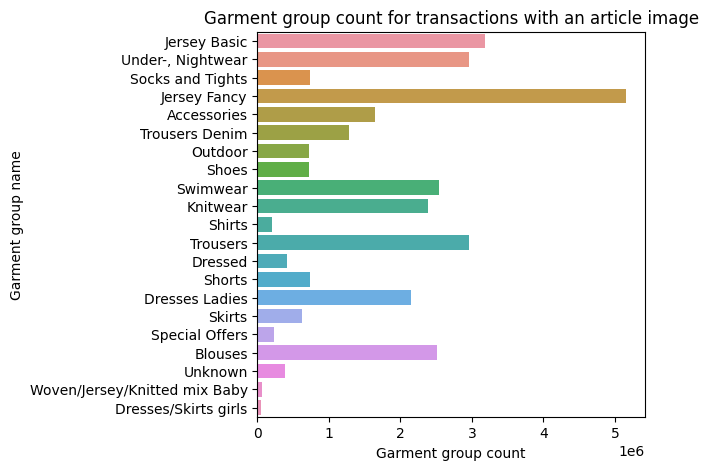

In [18]:
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(data=transactions_with_image, y='garment_group_name', order=garment_group_names)
ax.set_xlabel('Garment group count')
ax.set_ylabel('Garment group name')
ax.set_title('Garment group count for transactions with an article image')
plt.show()

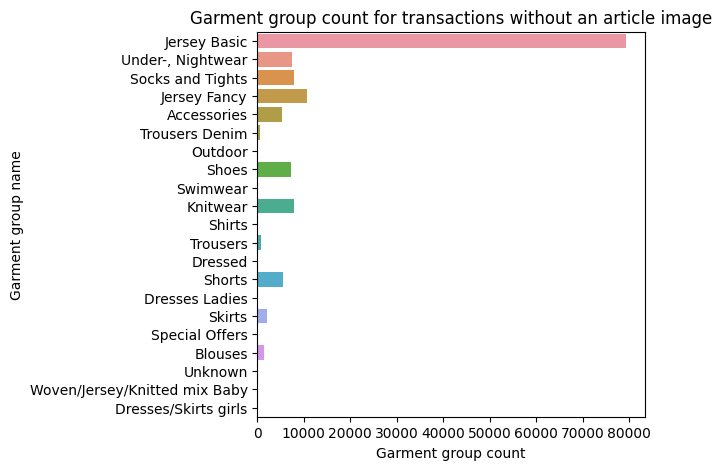

In [19]:
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(data=transactions_no_image, y='garment_group_name', order=garment_group_names)
ax.set_xlabel('Garment group count')
ax.set_ylabel('Garment group name')
ax.set_title('Garment group count for transactions without an article image')
plt.show()

Most transactions of articles without an image are from the Jersey Basic category.

## Customers

In [20]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [21]:
# show for each column in customers the NaN count and ratio
customers.isna().sum().to_frame().rename(columns={0: 'NaN count'}).assign(
    ratio=lambda x: x['NaN count']/customers.shape[0]
)

,NaN count,ratio
customer_id,0,0.000000
FN,895050,0.652378
Active,907576,0.661508
club_member_status,6062,0.004418
fashion_news_frequency,16009,0.011669
age,15861,0.011561
postal_code,0,0.000000


There are missing values in most columns. However, `FN` and `Active` seem to have a lot of NaN's. Let's take a closer look.

In [22]:
print(f"Unique values in FN: \t\t{customers['FN'].unique()}")
print(f"Unique values in Active: \t{customers['Active'].unique()}")

Unique values in FN: 		[nan  1.]
Unique values in Active: 	[nan  1.]


NaN can be converted to the value 0 for both `FN` and `Active`

### Fashion news frequency

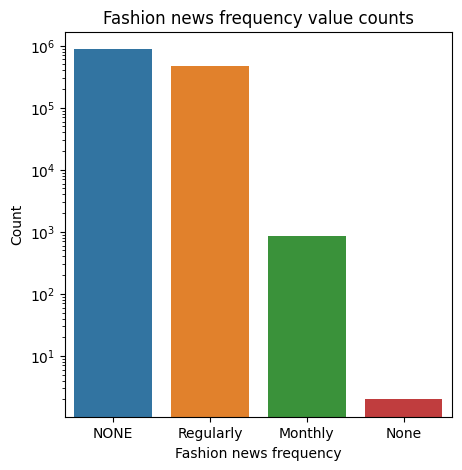

In [23]:
# plot all value counts of the fashion_news_frequency column with a log scale
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(data=customers, x='fashion_news_frequency', order=customers['fashion_news_frequency'].value_counts().index)
ax.set_xlabel('Fashion news frequency')
ax.set_ylabel('Count')
ax.set_title('Fashion news frequency value counts')
ax.set_yscale('log')
plt.show()


In [24]:
# look for rows where FN is NaN and fashion_news_frequency is 'Monthly'
fn_nan_monthly = customers[['FN', 'fashion_news_frequency']][(customers['FN'].isna()) & (customers['fashion_news_frequency'] == 'Monthly')]
print(f"In {fn_nan_monthly.shape[0]/customers.shape[0]:.6%} of rows, FN == NaN and fashion_news_frequency == 'Monthly'")
fn_nan_monthly

In 0.000948% of rows, FN == NaN and fashion_news_frequency == 'Monthly'


,FN,fashion_news_frequency
28322,NaN,Monthly
110430,NaN,Monthly
281549,NaN,Monthly
334022,NaN,Monthly
365258,NaN,Monthly
469382,NaN,Monthly
534054,NaN,Monthly
781765,NaN,Monthly
1167808,NaN,Monthly
1203225,NaN,Monthly


In [25]:
# look for rows where FN is NaN and fashion_news_frequency is 'Regularly'
fn_nan_regularly = customers[['FN', 'fashion_news_frequency']][(customers['FN'].isna()) & (customers['fashion_news_frequency'] == 'Regularly')]
print(f"In {fn_nan_regularly.shape[0]/customers.shape[0]:.6%} of rows, FN == NaN and fashion_news_frequency == 'Regularly'")
fn_nan_regularly

In 0.153501% of rows, FN == NaN and fashion_news_frequency == 'Regularly'


,FN,fashion_news_frequency
248,NaN,Regularly
273,NaN,Regularly
1769,NaN,Regularly
2731,NaN,Regularly
2941,NaN,Regularly
...,...,...
1365686,NaN,Regularly
1367492,NaN,Regularly
1367879,NaN,Regularly
1370291,NaN,Regularly


In [26]:
# look for rows where FN is 1 and fashion_news_frequency is 'NONE'
fn_1_NONE = customers[['FN', 'fashion_news_frequency']][(customers['FN'] == 1) & (customers['fashion_news_frequency'] == 'NONE')]
print(f"In {fn_1_NONE.shape[0]/customers.shape[0]:.6%} of rows, FN == 1 and fashion_news_frequency == 'NONE'")
fn_1_NONE

In 0.057508% of rows, FN == 1 and fashion_news_frequency == 'NONE'


,FN,fashion_news_frequency
335,1.0,NONE
4625,1.0,NONE
4744,1.0,NONE
6818,1.0,NONE
11518,1.0,NONE
...,...,...
1362264,1.0,NONE
1362670,1.0,NONE
1363240,1.0,NONE
1366098,1.0,NONE


In [27]:
# look for rows where FN is 1 and fashion_news_frequency is None
fn_1_None = customers[['FN', 'fashion_news_frequency']][(customers['FN'] == 1) & (customers['fashion_news_frequency'] == 'None')]
print(f"In {fn_1_None.shape[0]/customers.shape[0]:.6%} of rows, FN == 1 and fashion_news_frequency == 'None'")
fn_1_None

In 0.000146% of rows, FN == 1 and fashion_news_frequency == 'None'


,FN,fashion_news_frequency
898114,1.0,None
1356686,1.0,None
